# Lesson 1 - What's your pet

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

In [34]:
!activate tf_gpu
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [35]:
from fastai import *
from fastai.vision import *

## Looking at the data

We are going to use the **Oxford-IIIT Pet Dataset** which contains:

- 12 cat breeds
- 25 dogs breeds

In [36]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [37]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [38]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [39]:
anno_path = path/'annotations'
img_path = path/'images'

In [40]:
img_path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_140.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/keeshond_32.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_17.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_6.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_181.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_197.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_4.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_139.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_17.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_97.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_139.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_190.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_85.jpg'),

In [41]:
anno_path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README')]

In [42]:
np.random.seed(2)

In [43]:
pat = r'/([^/]+)_\d+.jpg$'
fnames = get_image_files(img_path)

In [49]:
data = ImageDataBunch.from_name_re(img_path, 
                                   fnames, 
                                   pat,
                                   valid_pct=0.15,
                                   ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         max_rotate=45, 
                                                         max_zoom=1.1, 
                                                         max_warp=0.1,
                                                         max_lighting=0.2, 
                                                         p_affine=0.75, 
                                                         p_lighting=0.75), 
                                   size=224, 
                                   bs=111,
                                   num_workers=20)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (6282 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,keeshond,saint_bernard,leonberger,Ragdoll
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1108 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
german_shorthaired,havanese,havanese,staffordshire_bull_terrier,shiba_inu
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

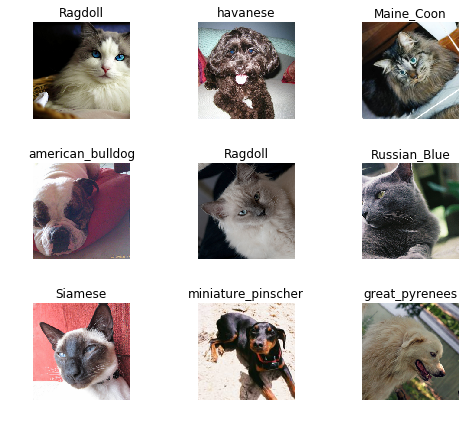

In [50]:
data.show_batch(rows=3, figsize=(7,6))

In [51]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: Resnet152

Train for 20 epochs

In [52]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy, error_rate])
learn.model = torch.nn.DataParallel(learn.model)

In [53]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.787601,0.480649,0.886282,0.113718,00:47
1,0.838190,0.222968,0.939531,0.060469,00:43
2,0.485378,0.194264,0.939531,0.060469,00:42
3,0.343573,0.182407,0.940433,0.059567,00:41
4,0.279064,0.170244,0.947653,0.052347,00:42
5,0.240826,0.171811,0.948556,0.051444,00:41
6,0.201231,0.200021,0.938628,0.061372,00:41
7,0.176827,0.168332,0.952166,0.047834,00:41
8,0.155240,0.178958,0.954874,0.045126,00:42
9,0.139701,0.167661,0.959386,0.040614,00:42


In [52]:
interp = ClassificationInterpretation.from_learner(learn)

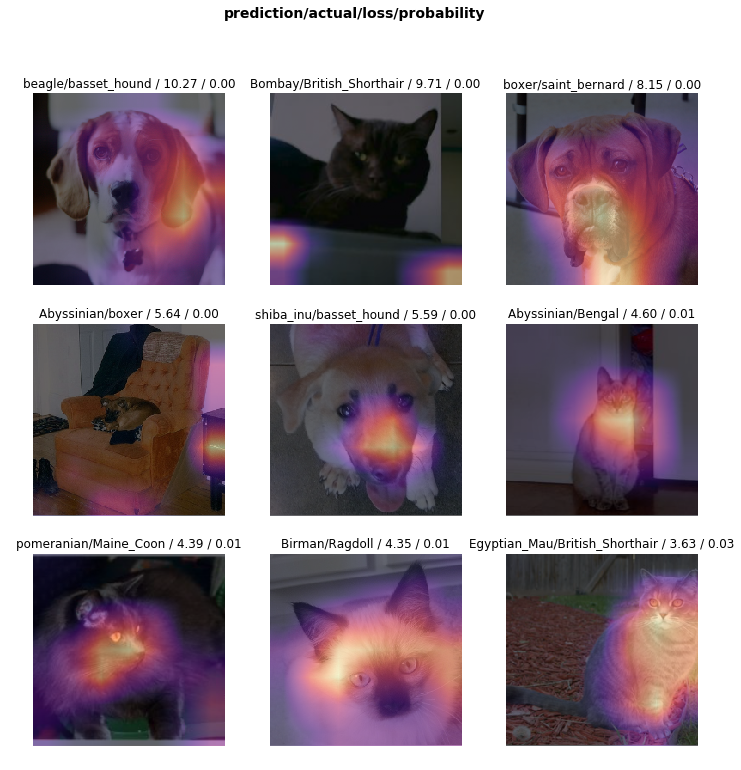

In [53]:
interp.plot_top_losses(9)

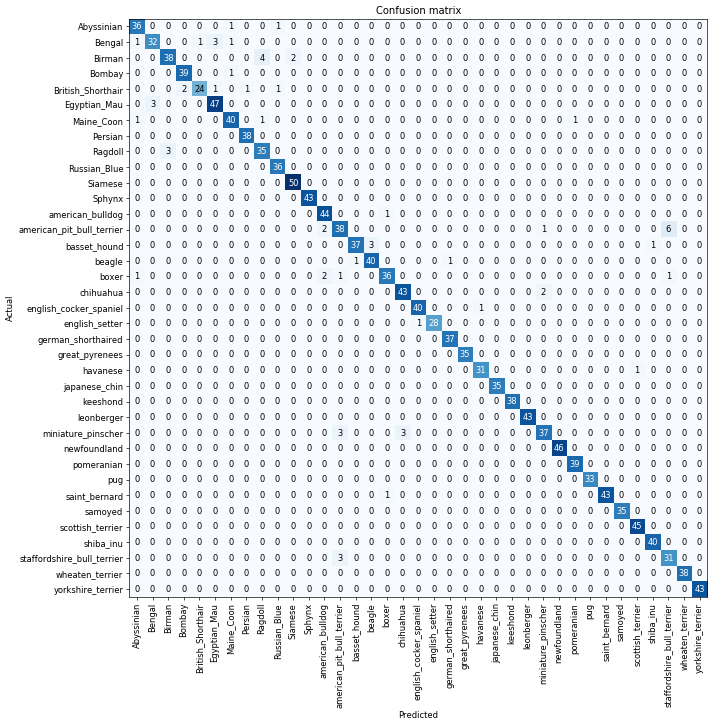

In [54]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Ragdoll', 3),
 ('american_bulldog', 'boxer', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('saint_bernard', 'boxer', 2)]

## Unfreezing, fine-tuning, and learning rates

In [35]:
learn.unfreeze()

In [36]:
learn.load('10epoch-99,5.resnet152.mdl')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,keeshond,saint_bernard,pug,wheaten_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ragdoll,leonberger,pug,Russian_Blue,pomeranian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=F

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


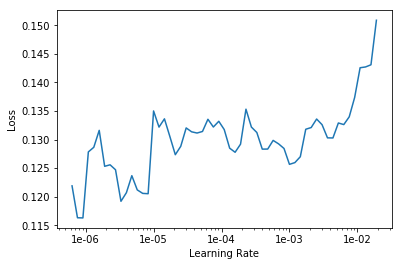

In [33]:
learn.recorder.plot()

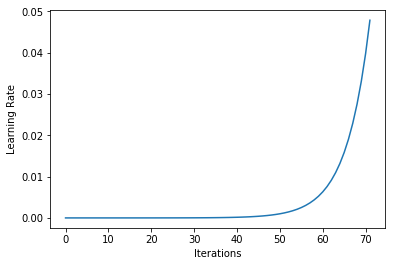

In [34]:
learn.recorder.plot_lr()

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.052125,0.200891,0.939784,0.060217,02:37
1,0.044378,0.193393,0.944520,0.055480,02:36
